### Importare pachete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/DL_PROJ'

/content/drive/MyDrive/DL_PROJ


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms

from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import time
import datetime
import csv

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.507,), std=(0.255,)),
])

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(sharpness_factor=0.3),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.507,), std=(0.255,)),
])

In [ ]:
class FER2013(Dataset):
    def __init__(self, root, split="train", transform=None):
        assert split in ["train", "test"], "split must be either 'train' or 'test'"

        csv_file = f"{root}/{split}.csv"

        with open(csv_file, "r", newline="") as file:
            self.samples = [
                (
                    torch.tensor(
                        [int(idx) for idx in row["pixels"].split()], dtype=torch.uint8
                    ).reshape(48, 48),
                    int(row["emotion"]) if "emotion" in row else None,
                )
                for row in csv.DictReader(file)
            ]

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_tensor, target = self.samples[idx]
        image = Image.fromarray(image_tensor.numpy())

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [ ]:
train_dataset = FER2013(root="./data/fer2013", split="train", transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)


validation_dataset = FER2013(root="./data/fer2013", split="test", transform=train_transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=True)

In [ ]:
print("Train split size:", len(train_dataset))
print("Validation split size:", len(validation_dataset))

Train split size: 28709
Validation split size: 7178


torch.Size([128, 1, 48, 48])


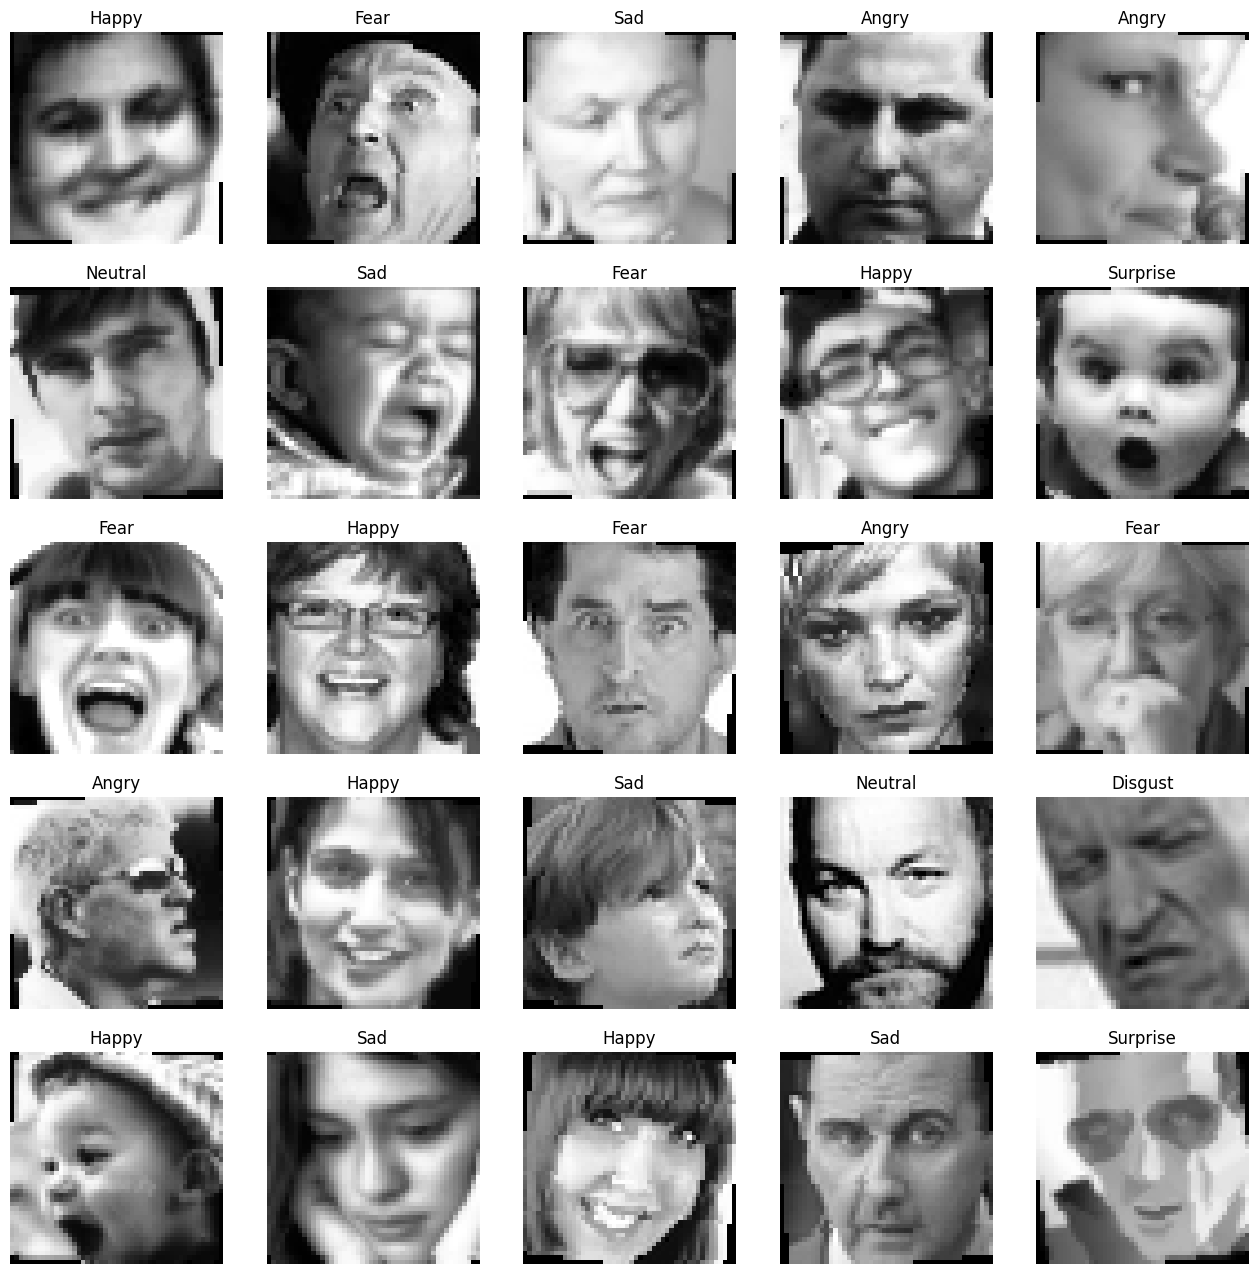

In [ ]:
labels_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

for images, labels in train_loader:
    plt.figure(figsize=(16, 16))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().transpose(1, 2, 0), cmap="gray")
        plt.title(labels_dict[labels[i].item()])
        plt.axis("off")
    break

images, labels = next(iter(train_loader))
print(images.shape)

In [ ]:
class DCNN(nn.Module):
    def __init__(self, img_height, img_width, num_classes):
        super(DCNN, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.4),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),

            nn.Flatten(),
            nn.Linear(512 * (img_width // 16) * (img_height // 16), 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.6),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)



In [ ]:
# Create an instance of the model
img_width, img_height, img_depth = 48, 48, 1
num_classes = 7
model = DCNN(img_height=img_height, img_width=img_width, num_classes=num_classes)

model = model.to(device)
print(model)

DCNN(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.4, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ELU(alpha=1.0)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.4, inplace=False)
    (14):

In [ ]:
# Print the model summary
summary(model, input_size=(img_depth, img_width, img_height))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,664
               ELU-2           [-1, 64, 48, 48]               0
       BatchNorm2d-3           [-1, 64, 48, 48]             128
            Conv2d-4           [-1, 64, 48, 48]         102,464
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         MaxPool2d-6           [-1, 64, 24, 24]               0
         Dropout2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,856
               ELU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 128, 24, 24]         147,584
      BatchNorm2d-12          [-1, 128, 24, 24]             256
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 128,

In [ ]:
@torch.no_grad()
def validate(model, criterion, validation_loader, device):
    model.eval()

    accuracy = 0.0
    loss = 0.0

    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)

        batch_loss = criterion(output, target).data.item() * data.shape[0]
        loss += batch_loss

        _, predicted = torch.max(output, axis=1)
        accuracy += (predicted == target).sum().item()

    accuracy /= len(validation_loader.dataset)
    loss /= len(validation_loader.dataset)
    return accuracy, loss

In [ ]:
def save_model(model, epoch, val_loss, optimizer):
    state = {
        'model': model.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss,
        'optimizer': optimizer.state_dict()
    }
    date_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    path = 'checkpoint_epoch_{}_val_loss_{:.3f}_{}.pt'.format(epoch, val_loss, date_time)
    torch.save(state, path)

def load_model(path, model, optimizer):
    state = torch.load(path)
    model.load_state_dict(state['model'])
    epoch = state['epoch']
    val_loss = state['val_loss']
    optimizer.load_state_dict(state['optimizer'])
    return epoch, val_loss

In [ ]:
def train(model, epochs, criterion, train_loader, validation_loader, optimizer, scheduler, device):
    start_train = time.time()

    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    best_validation_loss = None

    for epoch in range(1, epochs + 1):
        model.train()

        running_train_loss = 0.0
        accuracy = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = criterion(output, target)
            running_train_loss += loss.item() * data.shape[0]

            _, predicted = torch.max(output, axis=1)
            accuracy += (predicted == target).sum().item()

            model.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
          scheduler.step()

        train_losses.append(running_train_loss / len(train_loader.dataset))
        train_accuracies.append(accuracy / len(train_loader.dataset))
        validation_accuracy, validation_loss = validate(
            model, criterion, validation_loader, device
        )
        print(
            f"Epoch {epoch}/{epochs}, validation set: acc={validation_accuracy * 100:.2f}%, loss={validation_loss:.4f}"
        )
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        if not best_validation_loss or validation_loss < best_validation_loss:
            save_model(model, epoch, validation_loss, optimizer)
            best_validation_loss = validation_loss

    end_train = time.time()
    print(f"Training took {end_train - start_train:.2f}s")
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [ ]:
import_path = ""

if len(import_path) > 0:
    model = DCNN(num_classes=num_classes)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=0.0001)
    epoch, val_loss = load_model(import_path, model, optimizer)
    print(f"Imported model trained for {epoch} epochs, with validation loss: {val_loss}")

In [ ]:
epochs = 130
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=model,
    epochs=epochs,
    criterion=criterion,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

Epoch 1/130, validation set: acc=29.91%, loss=1.8497
Epoch 2/130, validation set: acc=33.07%, loss=1.8170
Epoch 3/130, validation set: acc=34.40%, loss=1.8032
Epoch 4/130, validation set: acc=36.24%, loss=1.7883
Epoch 5/130, validation set: acc=35.04%, loss=1.8004
Epoch 6/130, validation set: acc=36.26%, loss=1.7848
Epoch 7/130, validation set: acc=38.41%, loss=1.7663
Epoch 8/130, validation set: acc=40.54%, loss=1.7514
Epoch 9/130, validation set: acc=39.77%, loss=1.7507
Epoch 10/130, validation set: acc=40.16%, loss=1.7491
Epoch 11/130, validation set: acc=41.22%, loss=1.7404
Epoch 12/130, validation set: acc=41.59%, loss=1.7359
Epoch 13/130, validation set: acc=40.43%, loss=1.7462
Epoch 14/130, validation set: acc=42.55%, loss=1.7269
Epoch 15/130, validation set: acc=43.84%, loss=1.7146
Epoch 16/130, validation set: acc=44.11%, loss=1.7116
Epoch 17/130, validation set: acc=44.36%, loss=1.7141
Epoch 18/130, validation set: acc=45.25%, loss=1.7052
Epoch 19/130, validation set: acc=44.

In [ ]:
start_eval = time.time()
final_accuracy, _ = validate(model, criterion, validation_loader, device)
end_eval = time.time()
print(f"Final accuracy on validation split: {final_accuracy*100}%")
print(f"Evaluation took {end_eval - start_eval:.2f}s")

Final accuracy on validation split: 57.355809417665085%
Evaluation took 5.90s


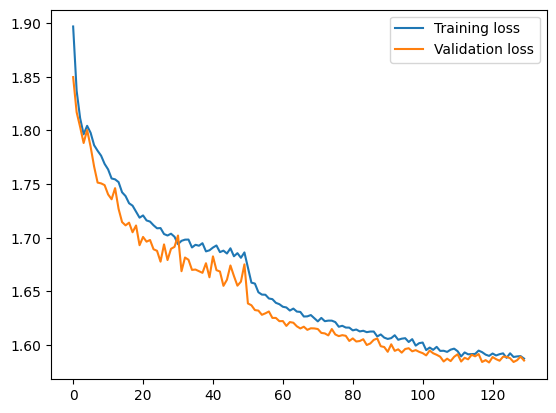

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend()
plt.show()

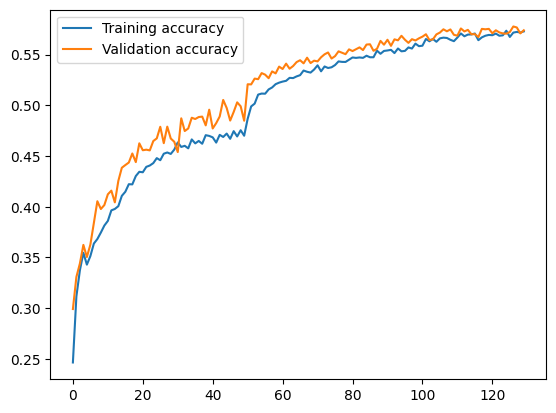

In [ ]:
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(validation_accuracies, label="Validation accuracy")
plt.legend()
plt.show()

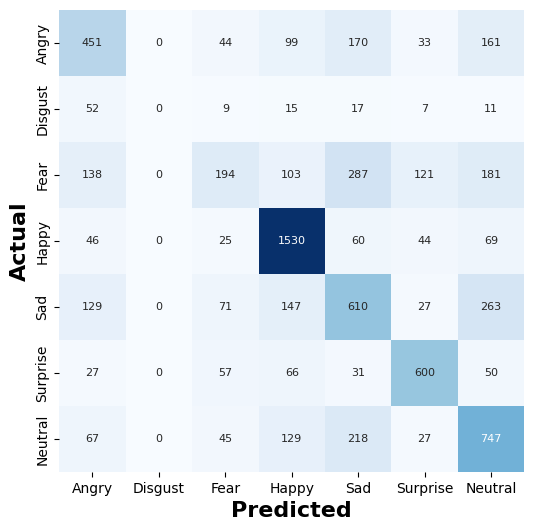

In [ ]:
predicted = []
actual = []

model.eval()
with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, axis=1)

        predicted.extend(preds.tolist())
        actual.extend(labels.tolist())

conf_matrix = confusion_matrix(
    actual,
    predicted,
)

emotions = list(labels_dict.values())

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=emotions,
    yticklabels=emotions,
    annot_kws={"size": 8},
)
plt.xlabel("Predicted", fontdict={"size": 16, "weight": "bold"})
plt.ylabel("Actual", fontdict={"size": 16, "weight": "bold"})
plt.show()